# **Loading the dataset**

In [ ]:
# We first import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.multivariate.pca import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.inspection import permutation_importance
import time
from sklearn.tree import export_text

In [ ]:
# Reading the data csv file
orig_data = pd.read_csv("healthcare-stroke-dataset.csv", index_col = 'id') # the name of the index column is specified here
orig_data.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1


In [ ]:
# there is only 1 entry where the gender is "other"
# Since it is hence not significant, we are dropping that row
orig_data.drop(orig_data[orig_data['gender'] == "Other"].index, inplace=True) # Dropping the Other value

# **Data Exploration**

In [ ]:
# We first get a preliminary sense of the dataset
orig_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


In [ ]:
orig_data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,4908.00000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.89456,0.048738
std,22.613575,0.296633,0.226084,45.285004,7.85432,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.50000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.10000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.10000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


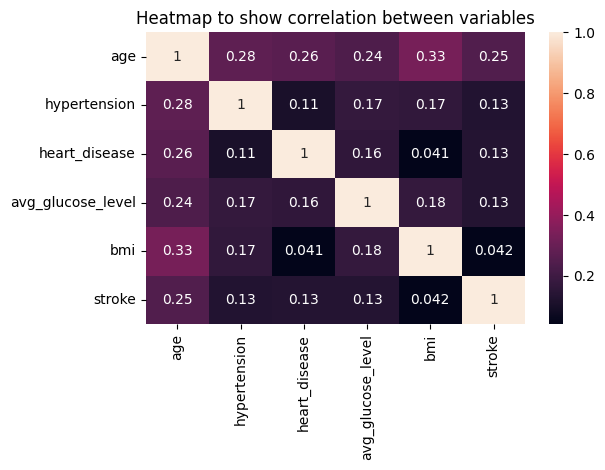

In [ ]:
# We will start of by looking at the correlation between the various variables here
# (those which have numeric values, we will create a more detailed heatmap with all variables further into the notebook).
num_data = orig_data[["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "stroke"]]
sns.heatmap(num_data.corr(), annot=True, fmt=".2g")
plt.title("Heatmap to show correlation between variables")
plt.tight_layout()

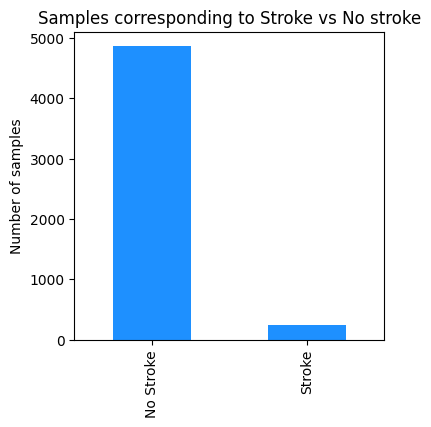

In [ ]:
# Plotting the number of samples which correspond to a stroke vs those which don't
fig = plt.figure(figsize = (4, 4))
orig_data["stroke"].value_counts().plot(kind="bar", color="dodgerblue")
plt.xticks(ticks=[0,1], labels=["No Stroke", "Stroke"])
plt.ylabel("Number of samples")
plt.title("Samples corresponding to Stroke vs No stroke")
plt.show()

The dataset is clearly very imbalanced, with a significanlty larger number of cases corresponding to 'no stroke'. This is something we will need to take into consideration while creating our classification model.

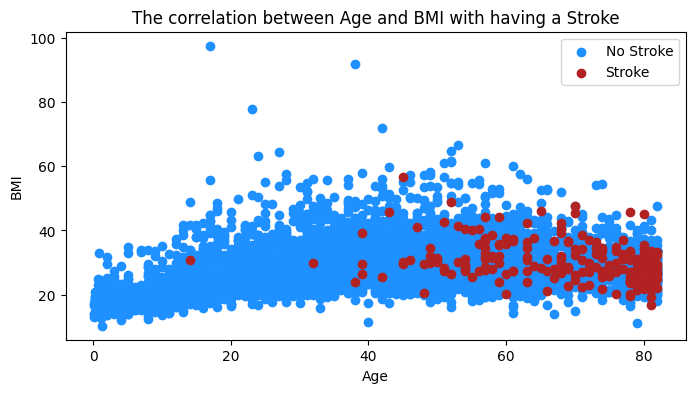

In [ ]:
# We will now compare the age vs BMI plot for people who had a stroke vs those who didn't
fig = plt.figure(figsize = (8, 4))
# if 'no stroke', we'd like the points to be plotted in red
plt.scatter(orig_data.age[orig_data.stroke==0],orig_data.bmi[orig_data.stroke==0],c="dodgerblue")

# if 'stroke', we'd like the points to be plotted in yellow
plt.scatter(orig_data.age[orig_data.stroke==1],orig_data.bmi[orig_data.stroke==1],c="firebrick")
plt.legend(["No Stroke", "Stroke"])
plt.xlabel("Age")
plt.ylabel("BMI")
plt.title("The correlation between Age and BMI with having a Stroke")
plt.show()

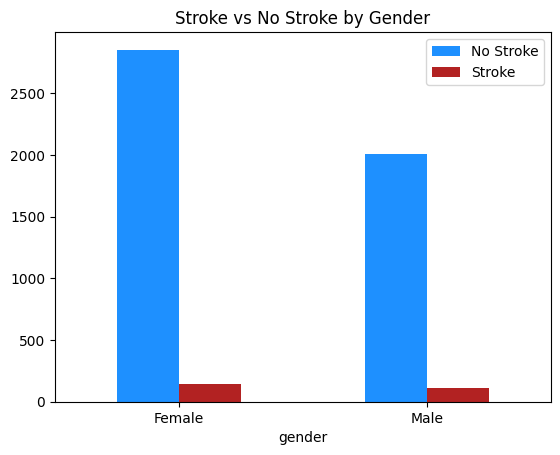

In [ ]:
# Let's visualize the gender crosstab, i.e. the distribution across gender categories
pd.crosstab(orig_data.gender, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Gender")
plt.show()

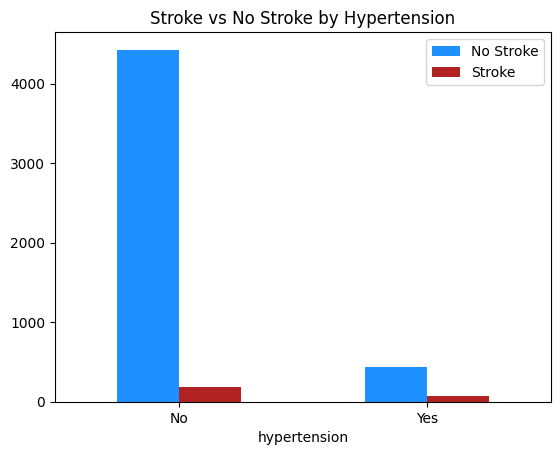

In [ ]:
# Let's visualize the distribution across hypertension categories
pd.crosstab(orig_data.hypertension, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Hypertension")
plt.xticks(ticks=[1,0], labels=["Yes", "No"])
plt.show()

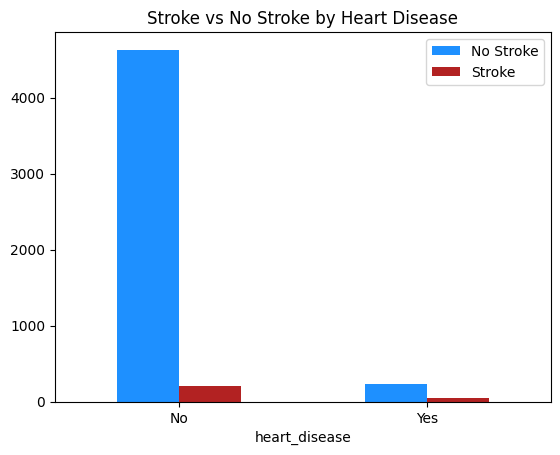

In [ ]:
# Let's visualize the distribution across heart disease categories
pd.crosstab(orig_data.heart_disease, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Heart Disease")
plt.xticks(ticks=[1,0], labels=["Yes", "No"])
plt.show()

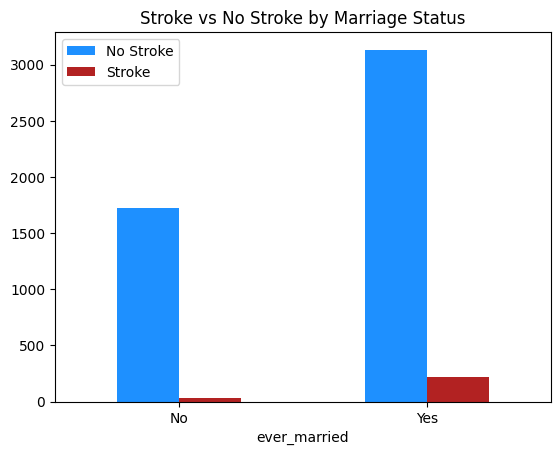

In [ ]:
# Let's visualize the distribution across marriage status
pd.crosstab(orig_data.ever_married, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Marriage Status")
plt.show()

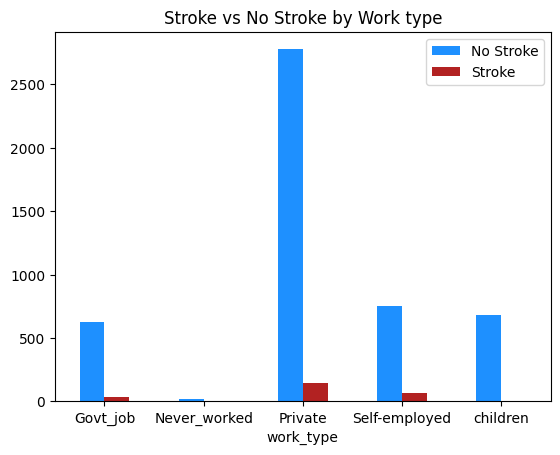

In [ ]:
# Let's visualize the distribution across work types
pd.crosstab(orig_data.work_type, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Work type")
plt.show()

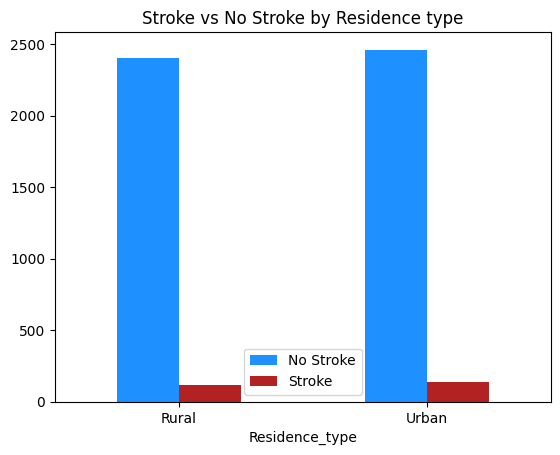

In [ ]:
# Let's visualize the distribution across Residence type
pd.crosstab(orig_data.Residence_type, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Residence type")
plt.show()

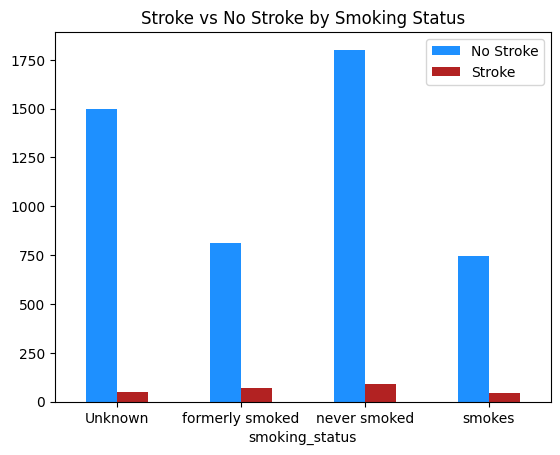

In [ ]:
# Let's visualize the distribution across smoking status
pd.crosstab(orig_data.smoking_status, orig_data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Smoking Status")
plt.show()

# **Data Pre-processing**

In [ ]:
# Before splitting the data into X and Y, we will perform some pre-processing on the data.
data = orig_data.values
data

array([['Male', 67.0, 0, ..., 36.6, 'formerly smoked', 1],
       ['Female', 61.0, 0, ..., nan, 'never smoked', 1],
       ['Male', 80.0, 0, ..., 32.5, 'never smoked', 1],
       ...,
       ['Female', 35.0, 0, ..., 30.6, 'never smoked', 0],
       ['Male', 51.0, 0, ..., 25.6, 'formerly smoked', 0],
       ['Female', 44.0, 0, ..., 26.2, 'Unknown', 0]], dtype=object)

In [ ]:
print("A sample entry:")
data[0]

A sample entry:


array(['Male', 67.0, 0, 1, 'Yes', 'Private', 'Urban', 228.69, 36.6,
       'formerly smoked', 1], dtype=object)

As can be seen, gender, ever_married, work_type, Residence_type and smoking_status are currently strings. We require numerical represenations of these.


For gender, ever_married and Residence_type, we can simply convert the values to binary labels, since all 3 only take 2 values:

**gender:** Female, Male

**ever_married:** Yes, No

**Residence_type:** Urban, Rural

In [ ]:
labelencoder = LabelEncoder()
data[:,0] = labelencoder.fit_transform(data[:,0]) # gender
data[:,4] = labelencoder.fit_transform(data[:,4]) # ever_married
data[:,6] = labelencoder.fit_transform(data[:,6]) # Residence_type

In [ ]:
print("Modified entry:")
data[0]

Modified entry:


array([1, 67.0, 0, 1, 1, 'Private', 1, 228.69, 36.6, 'formerly smoked', 1],
      dtype=object)

For work_type and smoking_status, we will need to create one hot encodings, since they can take 3 different values. We

In [ ]:
# First, we are creating numerical labels
# However, this is not enough, since it ends up giving importance to some labels over others
data[:,5] = labelencoder.fit_transform(data[:,5]) # work_type
data[:,9] = labelencoder.fit_transform(data[:,9]) # smoking_status

In [ ]:
data[0]

array([1, 67.0, 0, 1, 1, 2, 1, 228.69, 36.6, 1, 1], dtype=object)

In [ ]:
# work_type
ct = ColumnTransformer([("work_type", OneHotEncoder(), [5])], remainder = 'passthrough')
data = ct.fit_transform(data) # we will now apply it to the data
data[0]

array([0.0, 0.0, 1.0, 0.0, 0.0, 1, 67.0, 0, 1, 1, 1, 228.69, 36.6, 1, 1],
      dtype=object)

In [ ]:
# smoking_status
ct = ColumnTransformer([("smoking_status", OneHotEncoder(), [13])], remainder = 'passthrough')
data = ct.fit_transform(data) # we will now apply it to the data
data[0]

array([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1, 67.0, 0, 1, 1, 1,
       228.69, 36.6, 1], dtype=object)

In [ ]:
# converting the data type from Numpy array to Pandas
data = pd.DataFrame(data, columns = ["unknown-smoking", "formerly smoked","never smoked","smokes", "Govt job" , "Never worked", "Private job" ,"Self-employed", "children", "gender",	"age",	"hypertension",	"heart_disease",	"ever_married",	"Residence_type",	"avg_glucose_level",	"bmi", "stroke"])
data.head()

,unknown-smoking,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,children,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,67.0,0,1,1,1,228.69,36.6,1
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,61.0,0,0,1,0,202.21,NaN,1
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,80.0,0,1,1,0,105.92,32.5,1
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,49.0,0,0,1,1,171.23,34.4,1
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,79.0,1,0,1,0,174.12,24.0,1


In [ ]:
data = data.fillna(0) # any NaN value is substitued by a 0

The data is very imbalanced, with over 4000 entries corresponding to no stroke, and only 249 entries corresponding to a stroke occuring. If we do not address this issue, the model will simply learn to predict no stroke. Though the accuracy will be high on our dataset, it will not truly represent the model's accuracy in a real world situation. We hence undersample the no stroke class.

Since 249 entries will be chosen at random from the 4000+ no stroke ones, we first pre-processed the data. Now we will choose random samples from it, so that regardless of the values present in the randomly sampled dataset, the resultant overall representation remains the same.


In [ ]:
stroke = data.query("stroke == 1").sample(n=249, random_state = 12)
noStroke = data.query("stroke == 0").sample(n=249, random_state = 12)
data = stroke.append(noStroke)
data.head(10)
# shuffle the DataFrame rows
data = data.sample(frac = 1)
data.head(10)

<ipython-input-26-a07a214bed7a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = stroke.append(noStroke)


,unknown-smoking,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,children,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke
21,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,52.0,1,0,1,1,233.29,48.9,1
513,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,22.0,0,0,0,1,122.10,23.6,0
141,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,59.0,0,0,1,0,116.44,23.8,1
177,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,78.0,1,0,1,0,56.11,25.5,1
13,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,78.0,0,1,1,1,219.84,0.0,1
85,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,54.0,0,0,1,0,96.97,29.1,1
3419,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,5.0,0,0,0,1,84.50,15.8,0
1033,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,34.0,0,0,0,1,108.47,30.4,0
3428,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,62.0,0,0,1,0,98.05,27.9,0
882,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,74.0,1,0,1,0,57.51,31.7,0


### **Now that the data has been balanced, we will visualize some aspects of it again, to see if there are some more meaningful insights that can be drawn.**

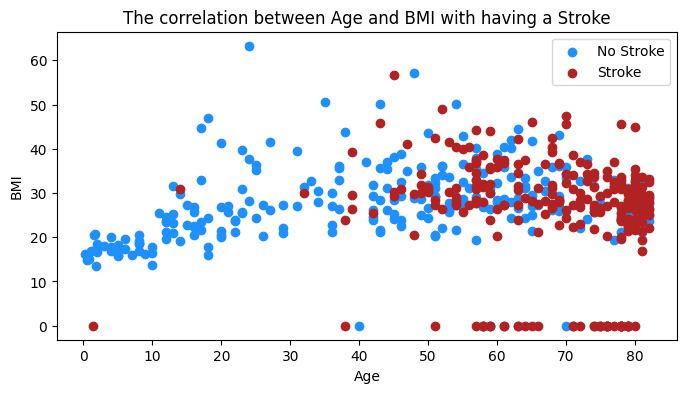

In [ ]:
# We will now compare the age vs BMI plot for people who had a stroke vs those who didn't
fig = plt.figure(figsize = (8, 4))
# if 'no stroke', we'd like the points to be plotted in red
plt.scatter(data.age[data.stroke==0],data.bmi[data.stroke==0],c="dodgerblue")

# if 'stroke', we'd like the points to be plotted in yellow
plt.scatter(data.age[data.stroke==1],data.bmi[data.stroke==1],c="firebrick")
plt.legend(["No Stroke", "Stroke"])
plt.xlabel("Age")
plt.ylabel("BMI")
plt.title("The correlation between Age and BMI with having a Stroke")
plt.show()

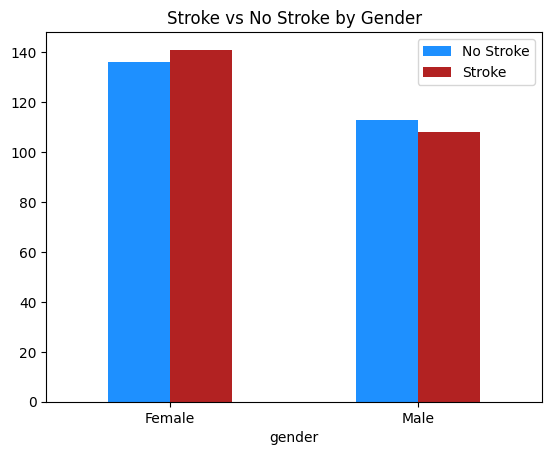

In [ ]:
# Let's visualize the gender crosstab, i.e. the distribution across gender categories
pd.crosstab(data.gender, data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Gender")
plt.xticks(ticks=[1,0], labels=["Male", "Female"])
plt.show()

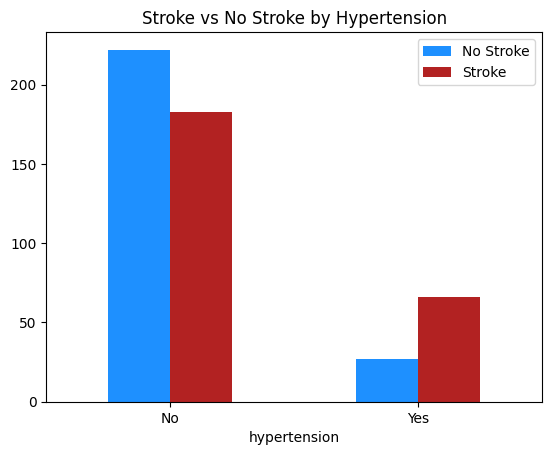

In [ ]:
# Let's visualize the distribution across hypertension categories
pd.crosstab(data.hypertension, data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Hypertension")
plt.xticks(ticks=[1,0], labels=["Yes", "No"])
plt.show()

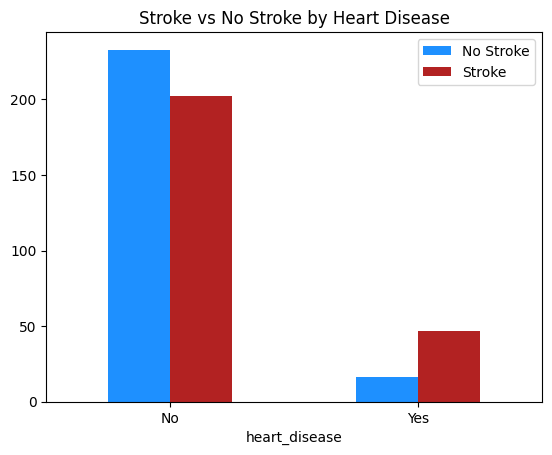

In [ ]:
# Let's visualize the distribution across heart disease categories again
pd.crosstab(data.heart_disease, data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Heart Disease")
plt.xticks(ticks=[1,0], labels=["Yes", "No"])
plt.show()

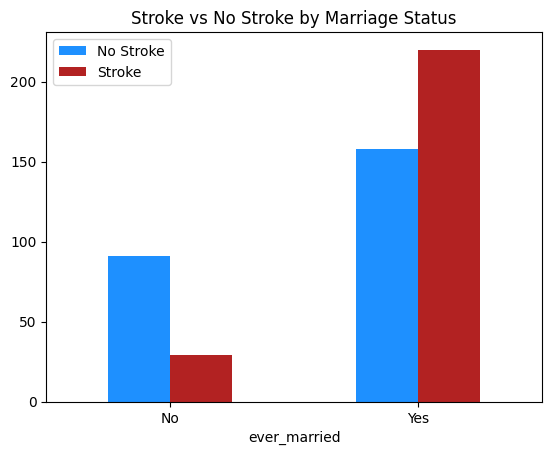

In [ ]:
# Let's visualize the distribution across marriage status
pd.crosstab(data.ever_married, data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Marriage Status")
plt.xticks(ticks=[1,0], labels=["Yes", "No"])
plt.show()

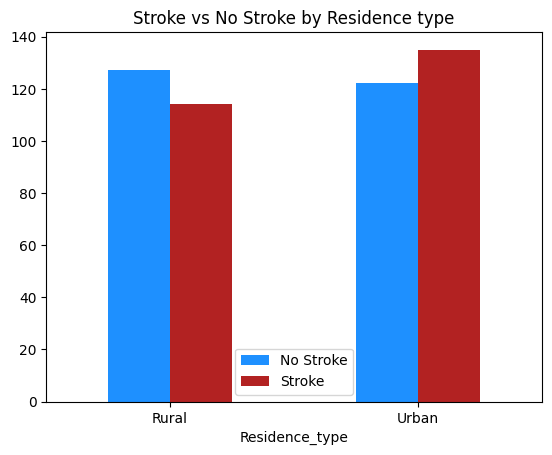

In [ ]:
pd.crosstab(data.Residence_type, data.stroke).plot(kind='bar', color=["dodgerblue","firebrick"], rot = 0)
plt.legend(labels=['No Stroke', 'Stroke'])
plt.title("Stroke vs No Stroke by Residence type")
plt.xticks(ticks=[1,0], labels=["Urban", "Rural"])
plt.show()

### **Splitting the dataset into X and y**

In [ ]:
# X and y
X = data.iloc[:,0:17]
y = data.iloc[:,17].values
X.head()

,unknown-smoking,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,children,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi
21,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,52.0,1,0,1,1,233.29,48.9
513,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,22.0,0,0,0,1,122.10,23.6
141,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,59.0,0,0,1,0,116.44,23.8
177,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,78.0,1,0,1,0,56.11,25.5
13,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,78.0,0,1,1,1,219.84,0.0


From both the smoking and work_type classes, we can drop one class each since  n-1 classes are enough to determine the values of n variables.

In [ ]:
X = X.drop("unknown-smoking", axis = 1)
X.head()

,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,children,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi
21,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,52.0,1,0,1,1,233.29,48.9
513,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,22.0,0,0,0,1,122.10,23.6
141,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,59.0,0,0,1,0,116.44,23.8
177,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,78.0,1,0,1,0,56.11,25.5
13,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,78.0,0,1,1,1,219.84,0.0


In [ ]:
X = X.drop("children", axis = 1)
X.head()

,formerly smoked,never smoked,smokes,Govt job,Never worked,Private job,Self-employed,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi
21,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,52.0,1,0,1,1,233.29,48.9
513,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,22.0,0,0,0,1,122.10,23.6
141,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,59.0,0,0,1,0,116.44,23.8
177,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,78.0,1,0,1,0,56.11,25.5
13,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,78.0,0,1,1,1,219.84,0.0


The dataset is now in the desired format.

# **Decision Tree Model**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 100)

In [ ]:
# Feature Scaling
# to standardize the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train) # fit_transform, because it's learning the mean and st. deviation
X_test = sc.transform(X_test) # when you are testing the data, you want it to funtion with the same mean, SD. Do not want to compute new ones

In [ ]:
# create Decision tree
clf = DecisionTreeClassifier(max_depth=8)
# The value 8 was determined by experimentation. Beyond 8, the accuracy started decreasing

In [ ]:
# Train Decision Tree classifier
clf = clf.fit(X_train,y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
# Model accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7333333333333333


In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.62      0.71        40
           1       0.67      0.86      0.75        35

    accuracy                           0.73        75
   macro avg       0.75      0.74      0.73        75
weighted avg       0.76      0.73      0.73        75



In [ ]:
!pip install six

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


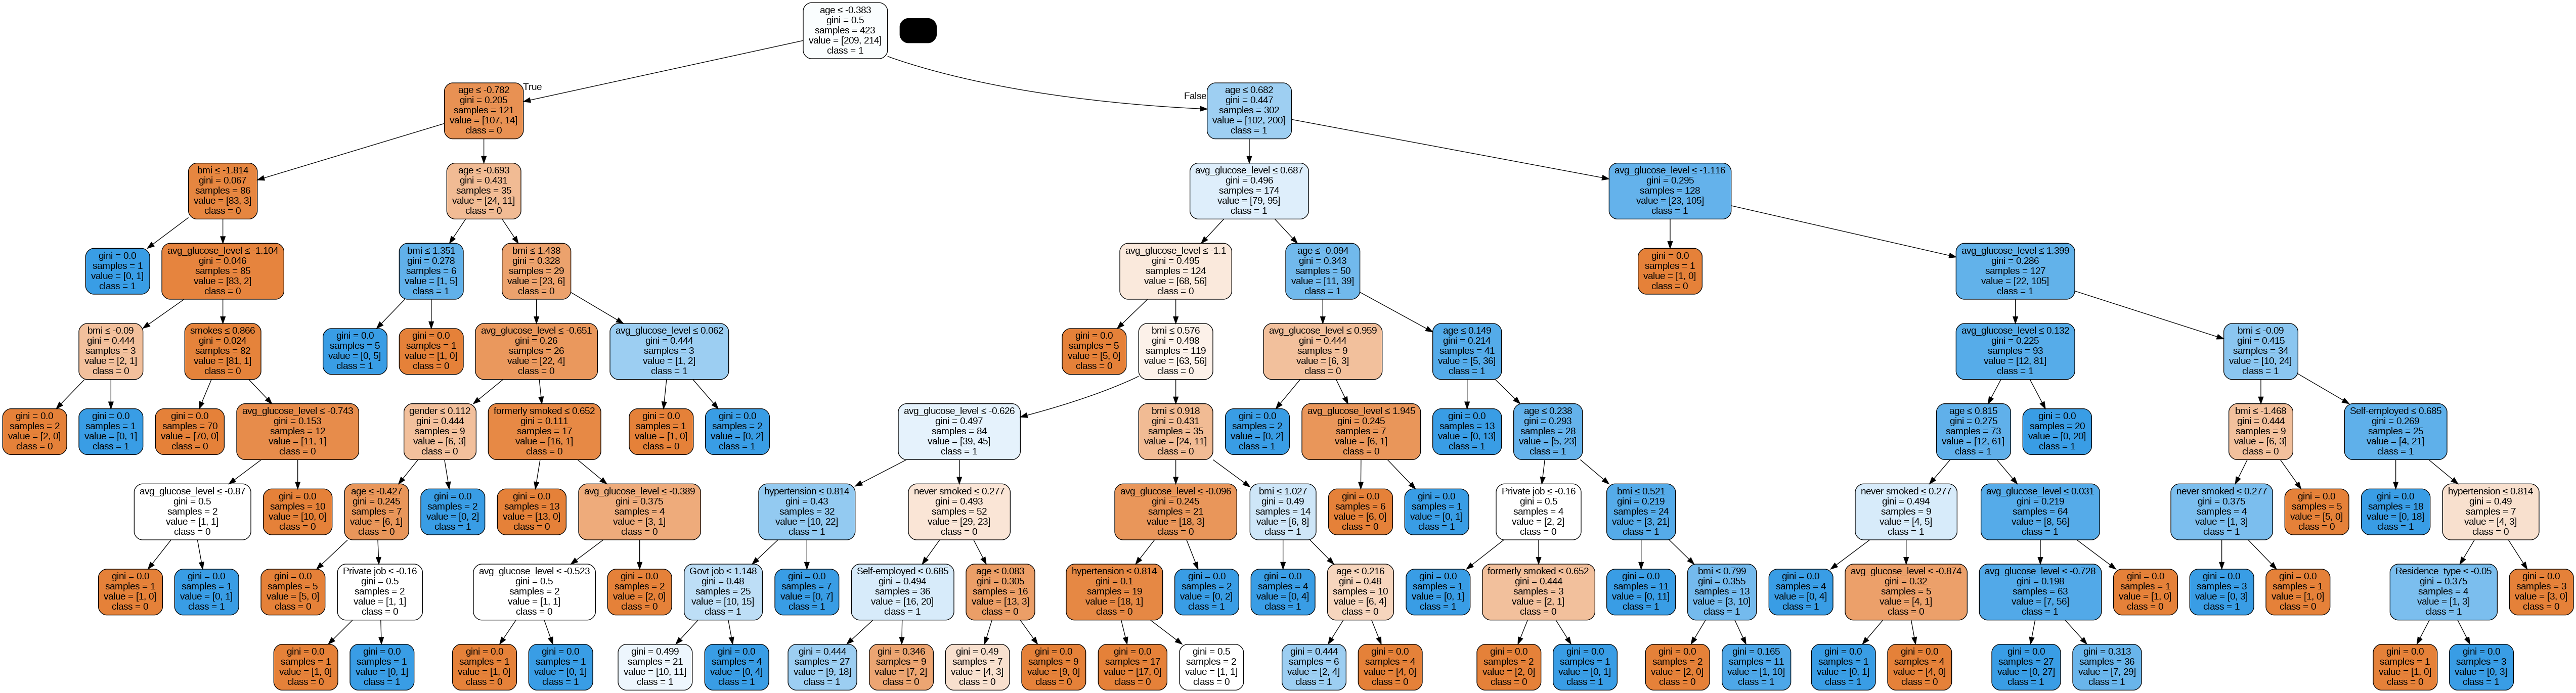

In [ ]:

feature_cols = ["formerly smoked","never smoked","smokes", "Govt job" , "Never worked", "Private job" ,"Self-employed	", "gender",	"age",	"hypertension",	"heart_disease",	"ever_married",	"Residence_type",	"avg_glucose_level",	"bmi"]
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('DecTree-Stroke.png')
Image(graph.create_png())

Accuracy: 0.7333333333333333


Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

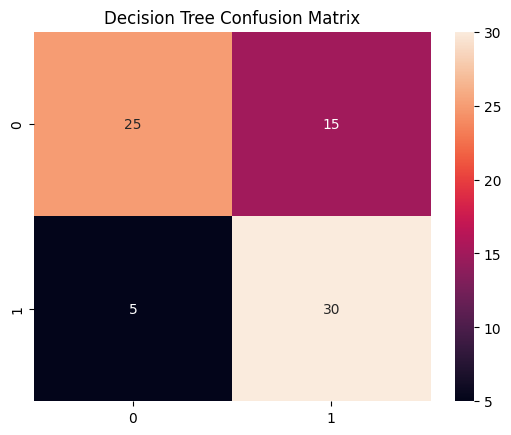

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
# Confusion Matrix
cm  = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = '');
plt.title('Decision Tree Confusion Matrix')

In [ ]:
model_fi = permutation_importance(clf, X_train, y_train)
model_fi['importances_mean']

array([0.00378251, 0.03546099, 0.00283688, 0.        , 0.        ,
       0.00661939, 0.02174941, 0.00756501, 0.33995272, 0.00189125,
       0.        , 0.        , 0.00567376, 0.19101655, 0.11016548])

In [ ]:

start_time = time.time()
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_cols)

Elapsed time to compute the importances: 1.313 seconds


<ipython-input-47-2e3807852b03>:5: UserWarning: Glyph 9 (	) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


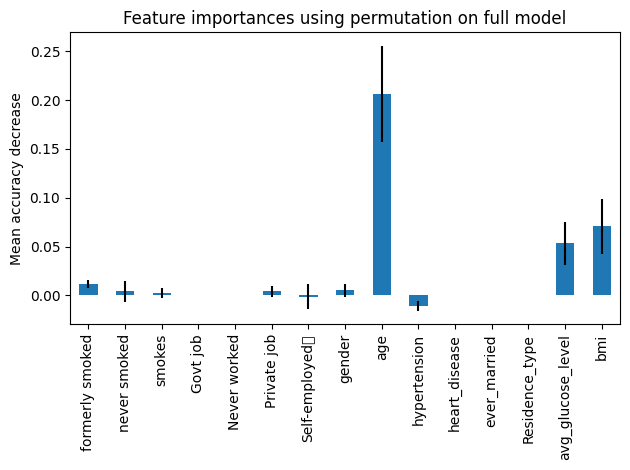

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
tree_rules = export_text(clf,
                        feature_names = feature_cols)
#print the result
print(tree_rules)

|--- age <= -0.38
|   |--- age <= -0.78
|   |   |--- bmi <= -1.81
|   |   |   |--- class: 1
|   |   |--- bmi >  -1.81
|   |   |   |--- avg_glucose_level <= -1.10
|   |   |   |   |--- bmi <= -0.09
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- bmi >  -0.09
|   |   |   |   |   |--- class: 1
|   |   |   |--- avg_glucose_level >  -1.10
|   |   |   |   |--- smokes <= 0.87
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- smokes >  0.87
|   |   |   |   |   |--- avg_glucose_level <= -0.74
|   |   |   |   |   |   |--- avg_glucose_level <= -0.87
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- avg_glucose_level >  -0.87
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- avg_glucose_level >  -0.74
|   |   |   |   |   |   |--- class: 0
|   |--- age >  -0.78
|   |   |--- age <= -0.69
|   |   |   |--- bmi <= 1.35
|   |   |   |   |--- class: 1
|   |   |   |--- bmi >  1.35
|   |   |   |   |--- class: 0
|   |   |--- age >  -0.69
|   |   |   |--- bmi <

# **Logistic Regression Model**

In [ ]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size = 0.10, random_state = 0)

In [ ]:
X_train_lr = sm.add_constant(X_train_lr)
X_test_lr = sm.add_constant(X_test_lr)
# the constant is added, otherwise is a violation of Gauss Markov property
classifier = sm.Logit(y_train_lr, X_train_lr)
model = classifier.fit()
model.summary()

         Current function value: 0.496922
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  448
Model:                          Logit   Df Residuals:                      432
Method:                           MLE   Df Model:                           15
Date:                Wed, 03 May 2023   Pseudo R-squ.:                  0.2831
Time:                        13:39:34   Log-Likelihood:                -222.62
converged:                      False   LL-Null:                       -310.53
Covariance Type:            nonrobust   LLR p-value:                 1.661e-29
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.3640      0.806     -4.172      0.000      -4.944      -1.784
formerly smoked       0.5020      0.381      1.318      0.188      -0.245       1.249
never smoked         -0.1530      0.353     -0.433      0.665      -0.845       0.539
smokes                0.4208      0.410      1.025      0.305      -0.384       1.225
Govt job             -0.7050      0.988     -0.714      0.475      -2.641       1.231
Never worked        -23.9744   3.92e+05  -6.12e-05      1.000   -7.68e+05    7.68e+05
Private job          -0.7374      0.952     -0.774      0.439      -2.604       1.129
Self-employed        -1.0251      1.006     -1.019      0.308      -2.998       0.947
gender               -0.2971      0.244     -1.218      0.223      -0.775       0.181
age                   0.0678      0.010      6.966      0.000       0.049       0.087
hypertension          0.4549      0.305      1.489      0.136      -0.144       1.053
heart_disease        -0.0503      0.360     -0.140      0.889      -0.757       0.656
ever_married          0.0997      0.395      0.252      0.801      -0.675       0.875
Residence_type        0.3310      0.238      1.391      0.164      -0.135       0.797
avg_glucose_level     0.0059      0.002      2.575      0.010       0.001       0.010
bmi                  -0.0299      0.012     -2.423      0.015      -0.054      -0.006
=====================================================================================
"""

Accuracy: 0.86


Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

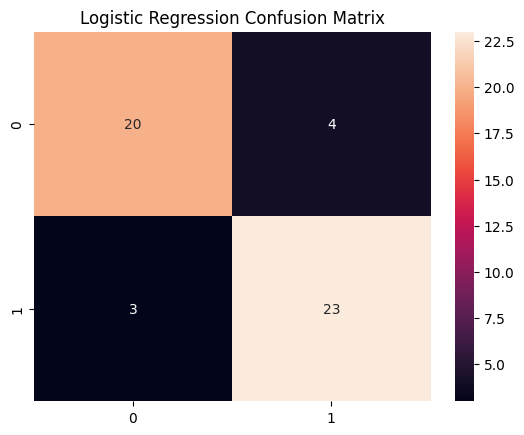

In [ ]:
y_pred_lr = model.predict(X_test_lr)
y_pred_lr = (y_pred_lr > 0.5) # the threshold value
print("Accuracy:", metrics.accuracy_score(y_test_lr, y_pred_lr))
# Confusion Matrix
cm  = confusion_matrix(y_test_lr, y_pred_lr)
sns.heatmap(cm, annot = True, fmt = '');
plt.title('Logistic Regression Confusion Matrix')

In [ ]:
print(metrics.classification_report(y_test_lr, y_pred_lr))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        24
           1       0.85      0.88      0.87        26

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50

